# import libraries

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
from albumentations import CenterCrop, Compose, Normalize
from albumentations.pytorch import ToTensorV2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (average_precision_score, balanced_accuracy_score,
                             matthews_corrcoef, roc_auc_score)
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader
from tqdm import tqdm

from clmodel.dataset import CLModelDataset
from clmodel.data_split import RepeatedStratifiedGroupKFold
from clmodel.model import EffnetB4ModelMO, FrozenEffnetB4ModelMO
from clmodel.utils import fix_seed

## load dataset

In [2]:
test_df = pd.read_csv("../../data/TGGATEs/processed/test_for_finding_types.csv")

In [3]:
test_df["path"] = test_df["path"].str.replace("HDD", "extHDD1")

In [4]:
ft_list = list(test_df.columns[3:11])
ft_list


['Proliferation, bile duct',
 'Ground glass appearance',
 'Increased mitosis',
 'Inclusion body, intracytoplasmic',
 'Deposit, pigment',
 'Single cell necrosis',
 'Vacuolization, cytoplasmic',
 'Swelling']

## fix seed

In [5]:
seed = 124
fix_seed(seed)


## define image preprocessing

In [6]:
image_size = 512

vl_transform = Compose([CenterCrop(image_size, image_size), Normalize(), ToTensorV2()])


In [7]:
test_dataset = CLModelDataset(
    test_df["path"].values, test_df[ft_list].values >= 0.5, transform=vl_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    drop_last=False,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

model_control = timm.create_model("tf_efficientnet_b4_ns", pretrained=True, num_classes=0)
model_control.eval()
model_control.to("cuda")

models_list = []
for ft in tqdm(ft_list + ["whole"]):
    if ft != "whole":
        save_dir = f"../../outputs/230305TGGATEs_ft_loo_{ft}_seed124_epoch5"
        models = [FrozenEffnetB4ModelMO(i, len(ft_list) - 1) for i in range(8)] + [EffnetB4ModelMO(num_classes=len(ft_list) - 1)]
    else:
        save_dir = "../../outputs/230305TGGATEs_model_seed124_epoch5"
        models = [FrozenEffnetB4ModelMO(i, len(ft_list)) for i in range(8)] + [EffnetB4ModelMO(num_classes=len(ft_list))]
    for i, model in enumerate(models):
        if i <= 7:
            model.load_state_dict(
                torch.load(f"{save_dir}/{i}/effnetb4_freeze{i}_fold0_best_loss.pth")
            )
            model.classifier = nn.Identity()
        else:
            model.model.load_state_dict(
                torch.load(f"{save_dir}/{i}/effnetb4_freeze{i}_fold0_best_loss.pth")
            )
            model.model.classifier = nn.Identity()
        model.to("cuda")
        model.eval()
    models_list.append(models)


100%|██████████| 9/9 [01:40<00:00, 11.16s/it]


In [8]:
features_control = []
features = [[[[] for k in range(9)] for i in range(9)] for ft in ft_list + ["whole"]]
with torch.no_grad():
    for im, _ in tqdm(test_loader):
        im = im.to("cuda")
        outputs = model_control(im)
        features_control.append(outputs.to("cpu").numpy())
        for i in range(len(ft_list) + 1):
            for j in range(9):
                outputs = models_list[i][j](im)
                for k, f in enumerate(outputs):
                    features[i][j][k].append(f.to("cpu").numpy())


100%|██████████| 1178/1178 [3:49:02<00:00, 11.67s/it] 


100%|██████████| 1178/1178 [2:18:20<00:00,  7.05s/it] 


## save features

In [8]:
import pickle

# with open("../../outputs/230308ft_validation_features_seed124_epoch5.pickle", "wb") as f:
#     pickle.dump({"features":features, "features_control":features_control}, f)

In [39]:
# features_control = np.concatenate(features_control)
# with open("../../outputs/230308ft_validation_features_control.pickle", "wb") as f:
#     pickle.dump(features_control, f)

In [9]:
with open("../../outputs/230308ft_validation_features_seed124_epoch5.pickle", "rb") as f:
    data = pickle.load(f)

features = data["features"]
features_control = data["features_control"]
# {"features":features, "features_control":features_control}

In [10]:
def eval(gt, pr):
    return [
        roc_auc_score(gt >= 0.5, pr),
        matthews_corrcoef(gt >= 0.5, pr >= 0.5),
        balanced_accuracy_score(gt >= 0.5, pr >= 0.5),
        (average_precision_score(gt >= 0.5, pr) + average_precision_score(gt < 0.5, - pr)) / 2,
    ]


def logreg(X, y, ft_i, train_idx, valid_idx):
    r = []
    X_train = X[train_idx]
    y_train = y[train_idx] >= 0.5
    X_valid = X[valid_idx]
    y_valid = y[valid_idx] >= 0.5
    lr = LogisticRegression(max_iter=100, n_jobs=8)
    lr.fit(X_train, y_train[:, ft_i])
    y_preds = lr.predict_proba(X_valid)[:, 1]
    rr = eval(y_valid[:, ft_i], y_preds)
    r.append(rr)
    return np.array(r)


In [11]:
rsgkf = RepeatedStratifiedGroupKFold(n_splits=5, random_state=42)
spl = rsgkf.split(features_control, (test_df[ft_list].values>=0.5).astype(np.int64), test_df["EG"].values)
train_idx, valid_idx = next(spl)

In [12]:
(test_df[ft_list].values>=0.5)[train_idx].sum(axis=0)

array([3523, 2750, 3240,  296,  403, 2995, 3879, 1168])

In [13]:
(test_df[ft_list].values>=0.5)[valid_idx].sum(axis=0)

array([1199, 1091,  208,  200,  200,  701,  100, 1987])

In [14]:
res_dict = {}
for ft_i in range(8):
    print(ft_list[ft_i])
    results = []
    results.append(logreg(np.concatenate(features_control), test_df[ft_list].values, ft_i, train_idx, valid_idx))

    for frozen in range(9):
        for depth in tqdm(range(9)):
            results.append(
                logreg(
                    np.concatenate(features[ft_i][frozen][depth]),
                    test_df[ft_list].values,
                    ft_i,
                    train_idx, valid_idx,
                )
            )
    results.append(
        logreg(
            test_df[[ft for i, ft in enumerate(ft_list) if i!=ft_i]].to_numpy(),
            test_df[ft_list].values,
            ft_i,
            train_idx, valid_idx,
        )
    )

    res_dict[ft_list[ft_i]] = results


Proliferation, bile duct


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Ground glass appearance


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Increased mitosis


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Inclusion body, intracytoplasmic


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 11%|█         | 1/9 [00:01<00:10,  1.29s/it]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Deposit, pigment


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Single cell necrosis


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Vacuolization, cytoplasmic


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Swelling


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [15]:
data = []
model_name = ["Control"] + ["Head"] + [f"Block {7-i}" for i in range(7)] + ["Full"]
layer_name = ["Stem"] + [f"Block {i+1}" for i in range(7)] + ["Head"]

for ft in ft_list:
    results = res_dict[ft]
    res = np.concatenate(results[1:-1]).reshape(9, 9, 4)
    r = res[0:1, :, :].copy()
    r[0, -1, 0] = results[0][0][0]
    r[0, -1, 1] = results[0][0][1]
    r[0, -1, 2] = results[0][0][2]
    r[0, -1, 3] = results[0][0][3]
    res = np.concatenate([r, res])
    for i in range(10):
        for j in range(9):
            data.append(
                (
                    model_name[i],
                    layer_name[j],
                    ft,
                    res[i, j, 0],
                    res[i, j, 1],
                    res[i, j, 2],
                    res[i, j, 3],
                )
            )
    data.append(
            (
                "Pathological Findings",
                "-",
                ft,
                results[-1][0, 0],
                results[-1][0, 1],
                results[-1][0, 2],
                results[-1][0, 3],
            )
        )

score_df = pd.DataFrame(
    data,
    columns=[
        "model",
        "layer",
        "pathological findings",
        "AUROC",
        "MCC",
        "Balanced Accuracy",
        "AP",
    ],
)
score_df.to_csv(
    "../../outputs/results/230721finding_type_validation_loo_seed124_epoch5.csv", index=False
)


In [20]:
score_df

model    layer     pathological findings     AUROC  \
0                  Control     Stem  Proliferation, bile duct  0.896421   
1                  Control  Block 1  Proliferation, bile duct  0.938158   
2                  Control  Block 2  Proliferation, bile duct  0.968936   
3                  Control  Block 3  Proliferation, bile duct  0.972933   
4                  Control  Block 4  Proliferation, bile duct  0.972741   
..                     ...      ...                       ...       ...   
723                   Full  Block 5                  Swelling  0.867931   
724                   Full  Block 6                  Swelling  0.815809   
725                   Full  Block 7                  Swelling  0.810827   
726                   Full     Head                  Swelling  0.817080   
727  Pathological Findings        -                  Swelling  0.816052   

          MCC  Balanced Accuracy        AP  
0    0.230107           0.579122  0.464976  
1    0.638737           0.839545  0.581823  
2    0.782962           0.950758  0.817201  
3    0.766453           0.930717  0.852656  
4    0.768363           0.932572  0.850484  
..        ...                ...       ...  
723  0.635271           0.760186  0.801064  
724  0.628687           0.750302  0.771260  
725  0.681468           0.788324  0.773547  
726  0.694995           0.793014  0.781445  
727  0.000000           0.500000  0.724638  

[728 rows x 7 columns]

In [21]:
os.system("mkdir ../../outputs/230309TGGATE_findingtype_freeze_loo_figures_seed124_epoch5")

mkdir: cannot create directory ‘../../outputs/230309TGGATE_findingtype_freeze_loo_figures_seed124_epoch5’: File exists


256

Proliferation, bile duct


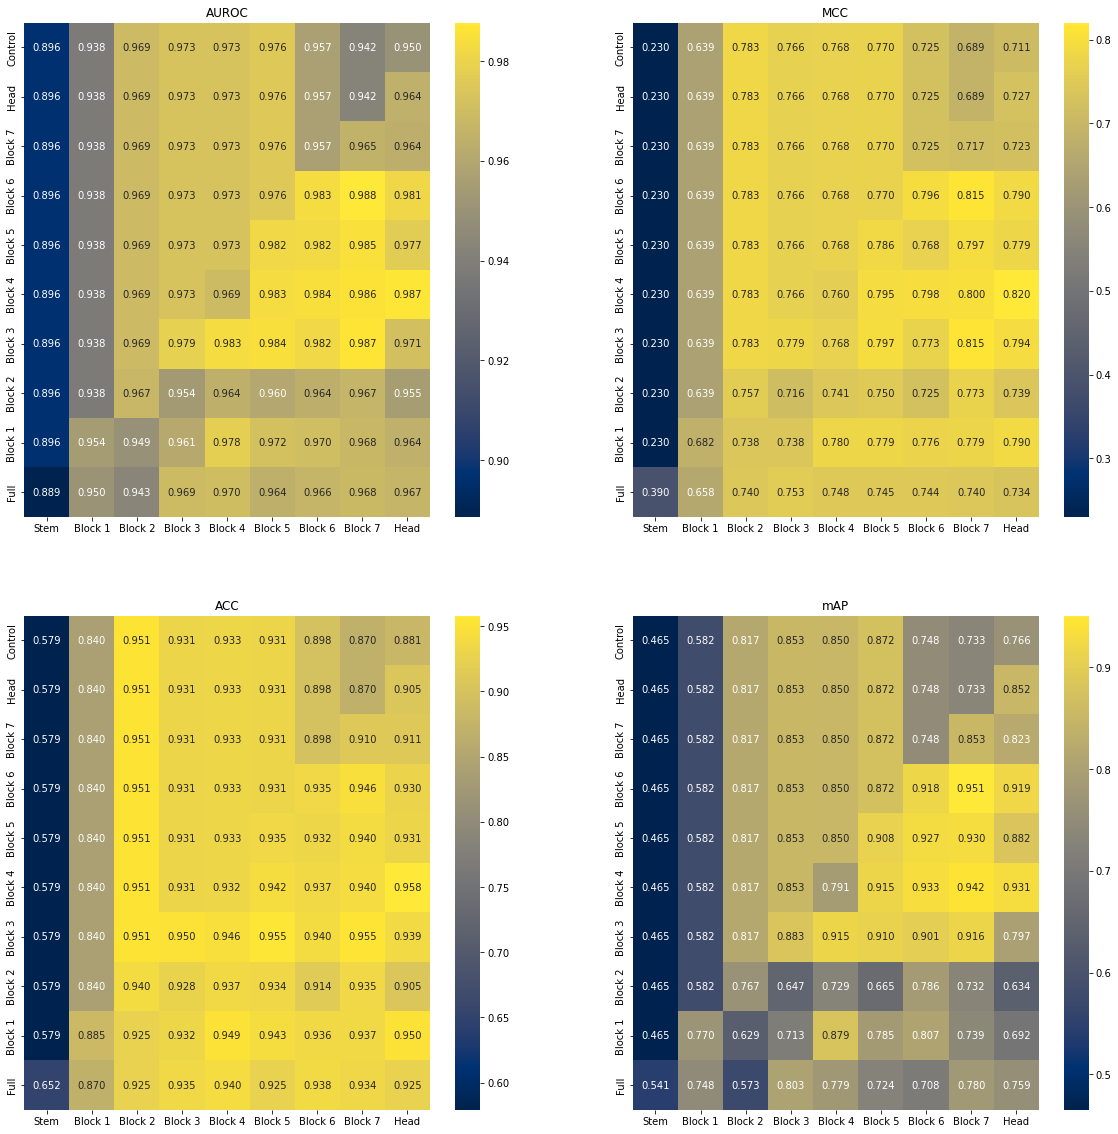

Ground glass appearance


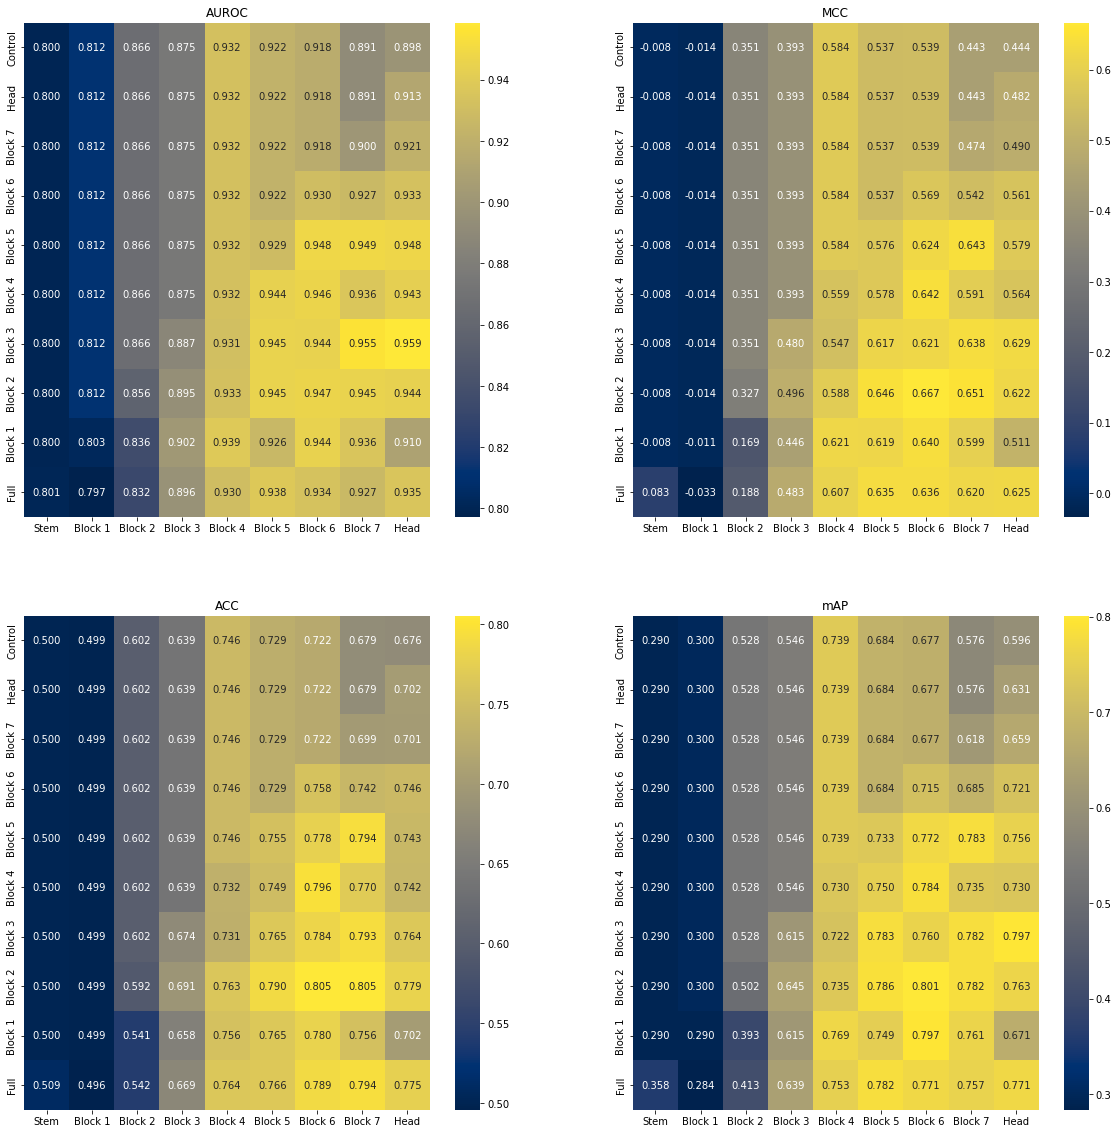

Increased mitosis


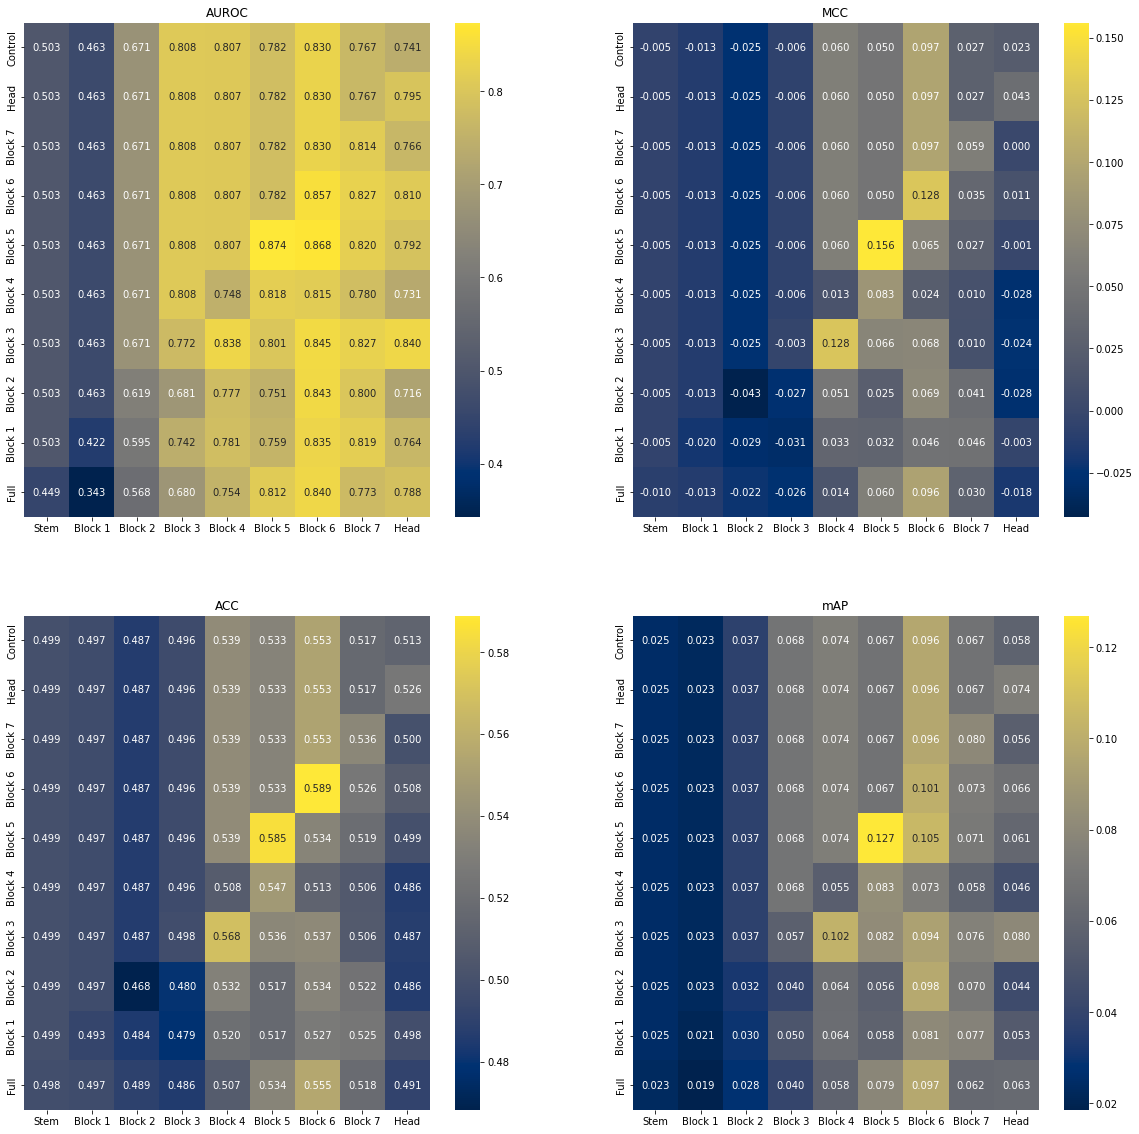

Inclusion body, intracytoplasmic


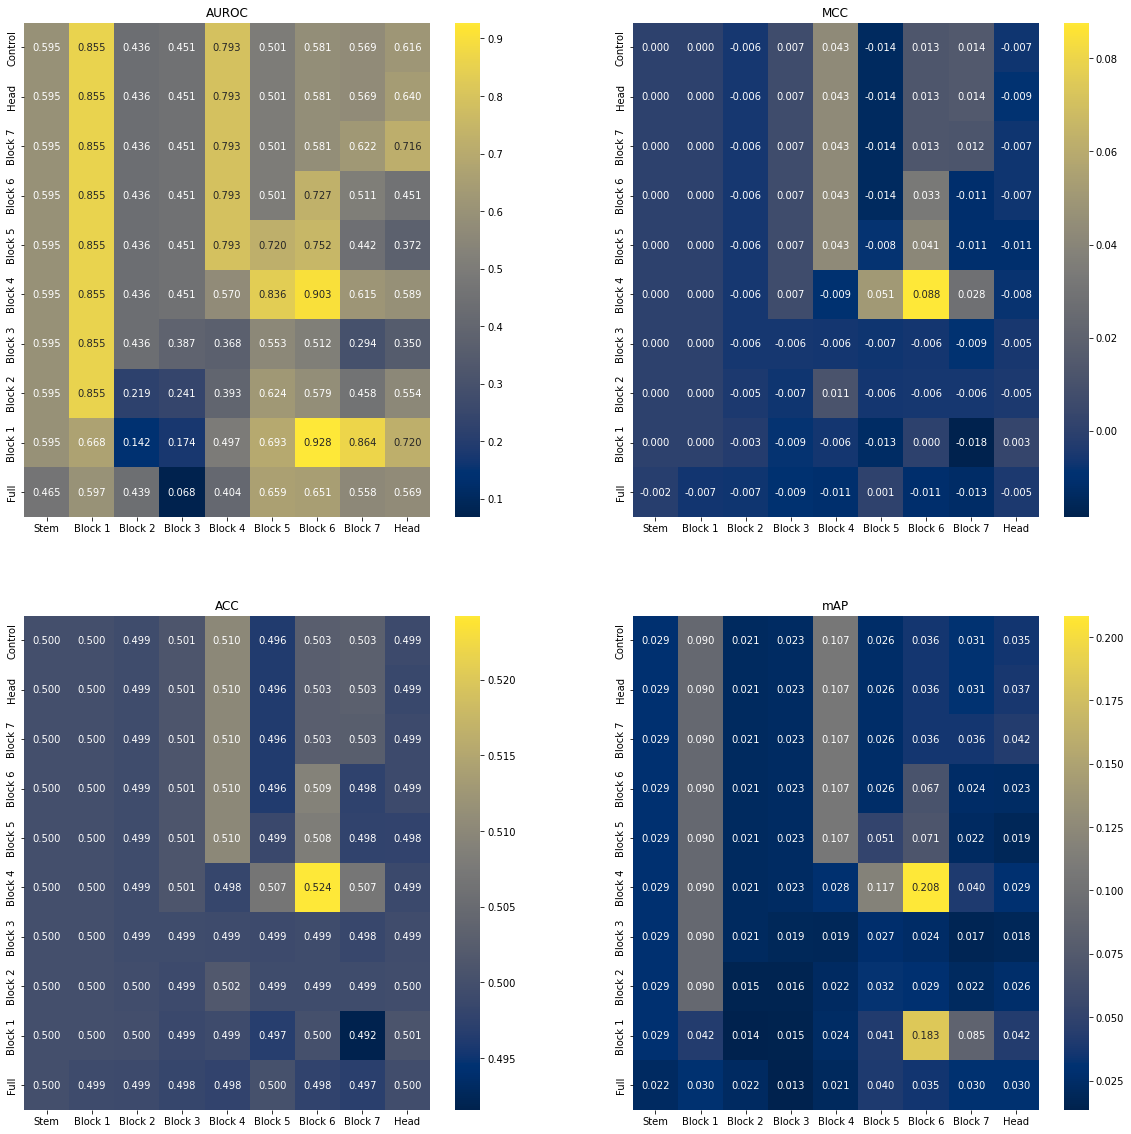

Deposit, pigment


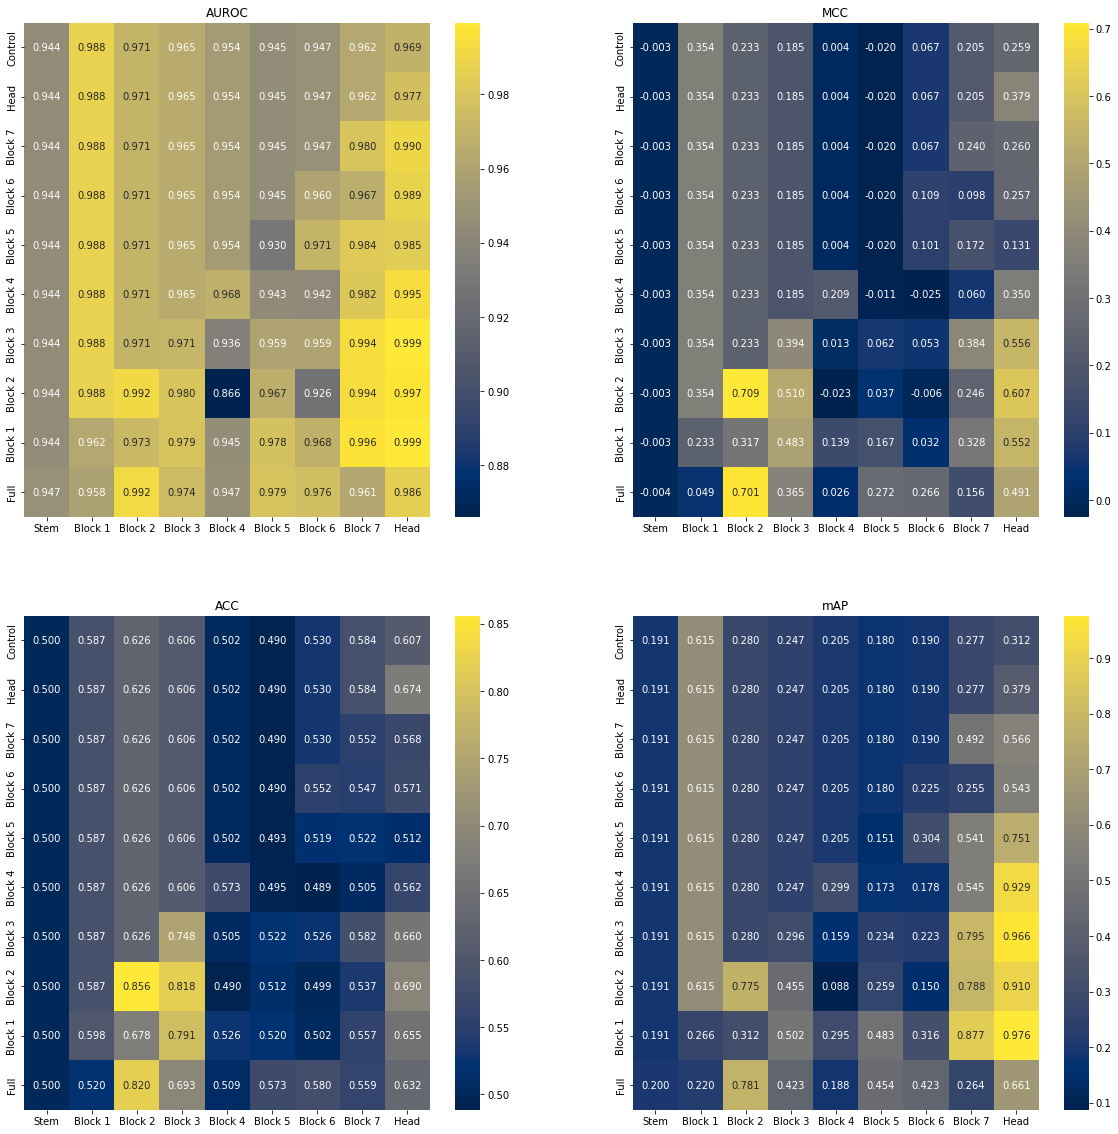

Single cell necrosis


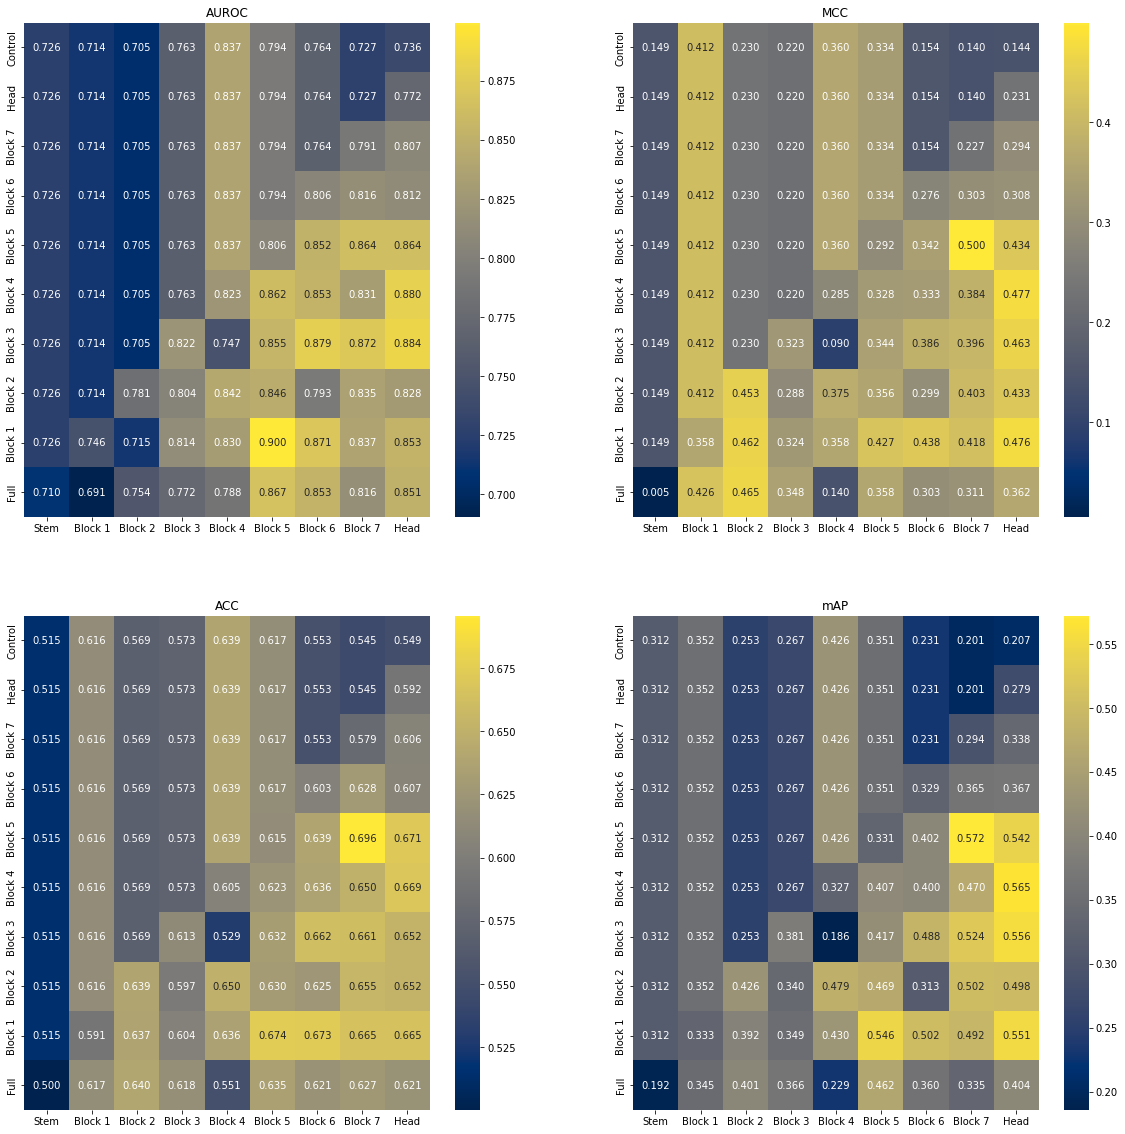

Vacuolization, cytoplasmic


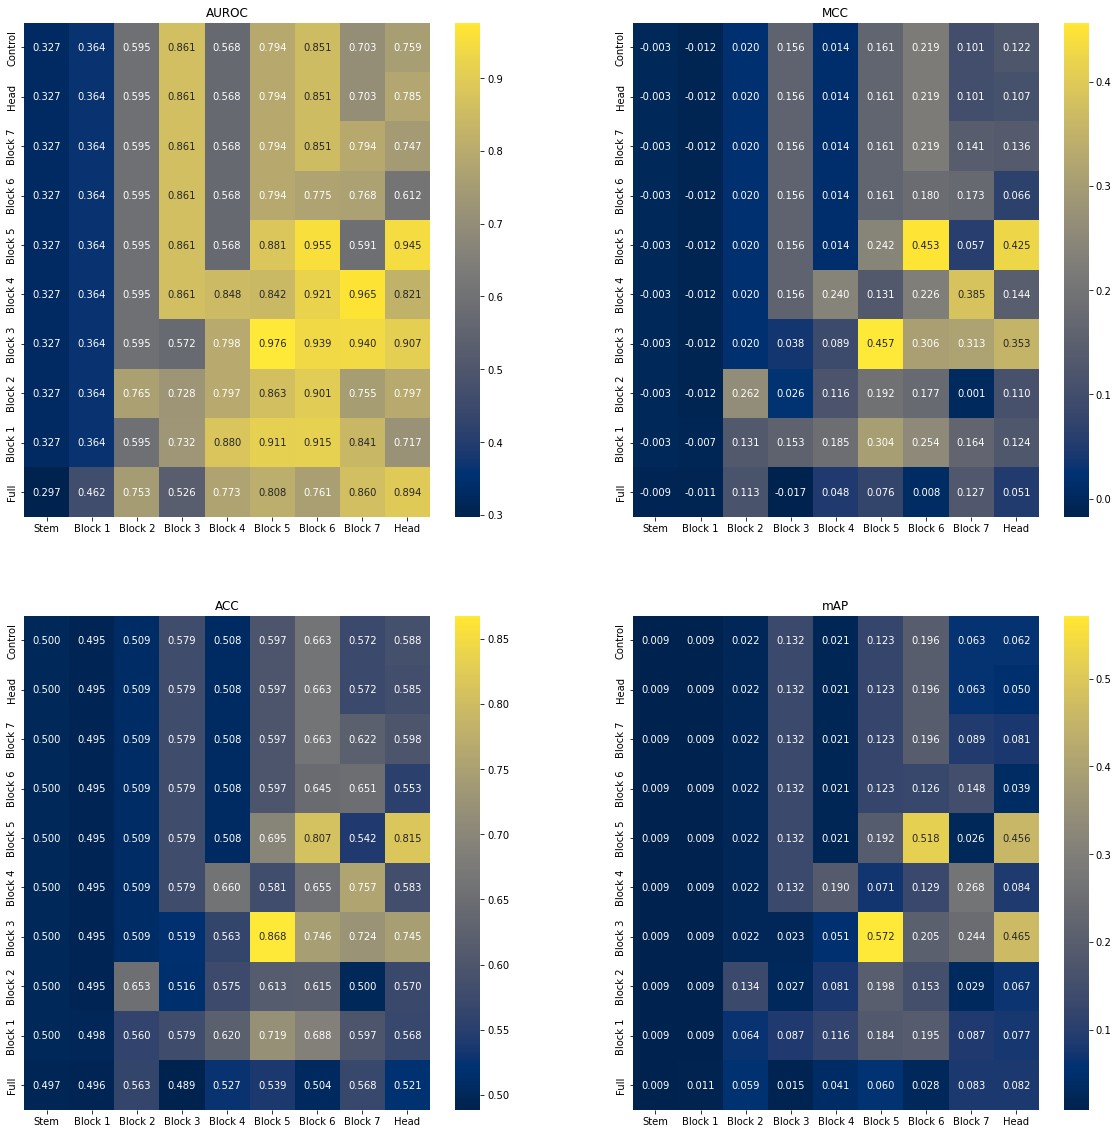

Swelling


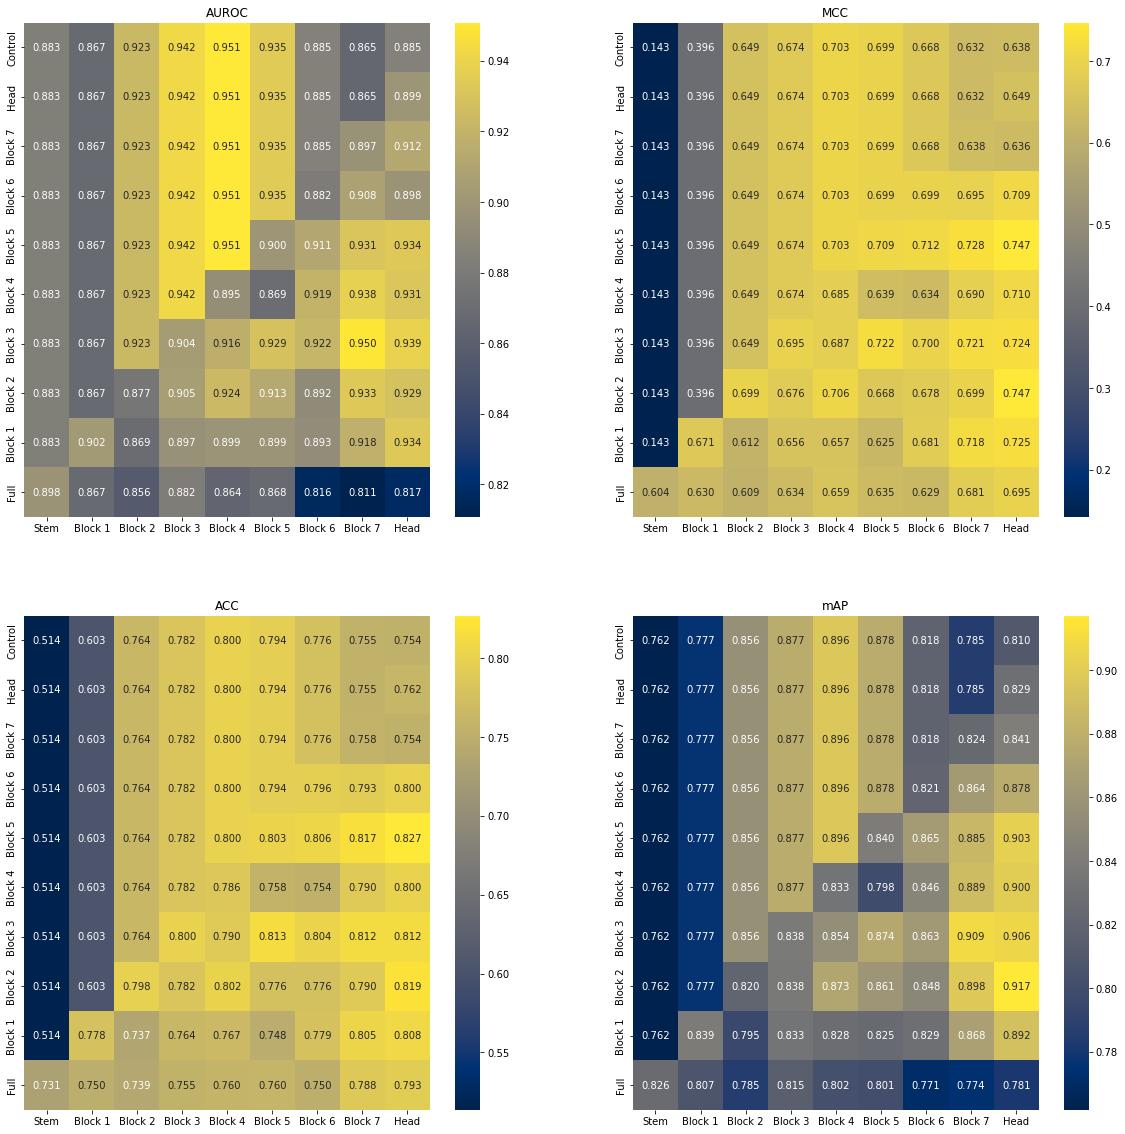

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["AUROC", "MCC", "ACC", "mAP"]
for ft in ft_list:
    results = res_dict[ft]
    res = np.concatenate(results[1:-1]).reshape(9, 9, 4)
    r = res[0:1, :, :].copy()
    r[0, -1, 0] = results[0][0][0]
    r[0, -1, 1] = results[0][0][1]
    r[0, -1, 2] = results[0][0][2]
    r[0, -1, 3] = results[0][0][3]
    res = np.concatenate([r, res])

    print(ft)
    fig = plt.figure(figsize=(20, 20))
    for i in range(4):
        df = pd.DataFrame(res[:, :, i], index=model_name, columns=layer_name)
        ax = fig.add_subplot(2, 2, i + 1)
        sns.heatmap(df, cmap="cividis", annot=True, fmt=".3f", ax=ax)
        ax.set_title(metrics[i])
    plt.savefig(f"../../outputs/230309TGGATE_findingtype_freeze_loo_figures_seed124_epoch5/{ft}.png", bbox_inches="tight")
    plt.show()


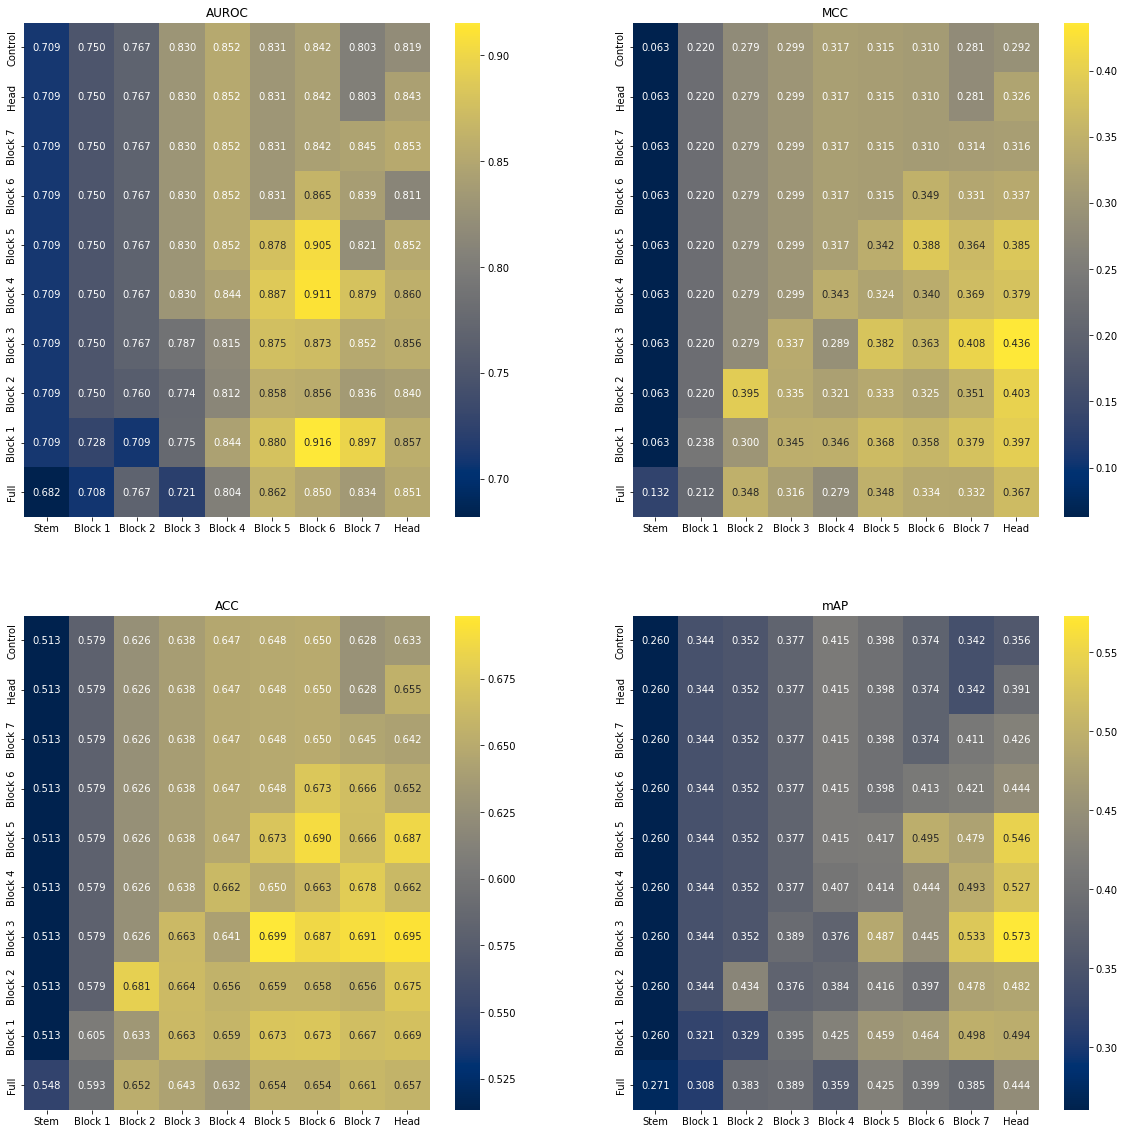

In [23]:
metrics = ["AUROC", "MCC", "ACC", "mAP"]
res_mean = 0
for ft in ft_list:
    results = res_dict[ft]
    res = np.concatenate(results[1:-1]).reshape(9, 9, 4)
    r = res[0:1, :, :].copy()
    r[0, -1, 0] = results[0][0][0]
    r[0, -1, 1] = results[0][0][1]
    r[0, -1, 2] = results[0][0][2]
    r[0, -1, 3] = results[0][0][3]
    res = np.concatenate([r, res])
    res_mean += res

fig = plt.figure(figsize=(20, 20))
for i in range(4):
    df = pd.DataFrame(res_mean[:, :, i]/len(ft_list), index=model_name, columns=layer_name)
    ax = fig.add_subplot(2, 2, i + 1)
    sns.heatmap(df, cmap="cividis", annot=True, fmt=".3f", ax=ax)
    ax.set_title(metrics[i])
plt.savefig(f"../../outputs/230309TGGATE_findingtype_freeze_loo_figures_seed124_epoch5/mean.png", bbox_inches="tight")
plt.show()


In [24]:
len(features)

9

In [26]:
for ft_i in range(8):
    results = []
    results.append(logreg(np.concatenate(features_control), test_df[ft_list].values, ft_i, train_idx, valid_idx))
    for frozen in range(9):
        for depth in tqdm(range(9)):
            results.append(
                logreg(
                    np.concatenate(features[8][frozen][depth]),
                    test_df[ft_list].values,
                    ft_i,
                    train_idx, valid_idx
                )
            )
    res_dict[f"whole_{ft_list[ft_i]}"] = results


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [27]:
data = []
model_name = ["Control"] + ["Head"] + [f"Block {7-i}" for i in range(7)] + ["Full"]
layer_name = ["Stem"] + [f"Block {i+1}" for i in range(7)] + ["Head"]

for ft in ft_list:
    results = res_dict[f"whole_{ft}"]
    res = np.concatenate(results[1:]).reshape(9, 9, 4)
    r = res[0:1, :, :].copy()
    r[0, -1, 0] = results[0][0][0]
    r[0, -1, 1] = results[0][0][1]
    r[0, -1, 2] = results[0][0][2]
    r[0, -1, 3] = results[0][0][3]
    res = np.concatenate([r, res])
    for i in range(10):
        for j in range(9):
            data.append(
                (
                    model_name[i],
                    layer_name[j],
                    ft,
                    res[i, j, 0],
                    res[i, j, 1],
                    res[i, j, 2],
                    res[i, j, 3],
                )
            )
    data.append(
            (
                "Pathological Findings",
                "-",
                ft,
                results[-1][0, 0],
                results[-1][0, 1],
                results[-1][0, 2],
                results[-1][0, 3],
            )
        )

score_df = pd.DataFrame(
    data,
    columns=[
        "model",
        "layer",
        "pathological findings",
        "AUROC",
        "MCC",
        "Balanced Accuracy",
        "AP",
    ],
)
score_df.to_csv(
    "../../outputs/results/230308finding_type_validation_seed124_epoch5.csv", index=False
)


In [29]:
os.system("mkdir ../../outputs/230308TGGATE_findingtype_figures_seed124_epoch5")

0

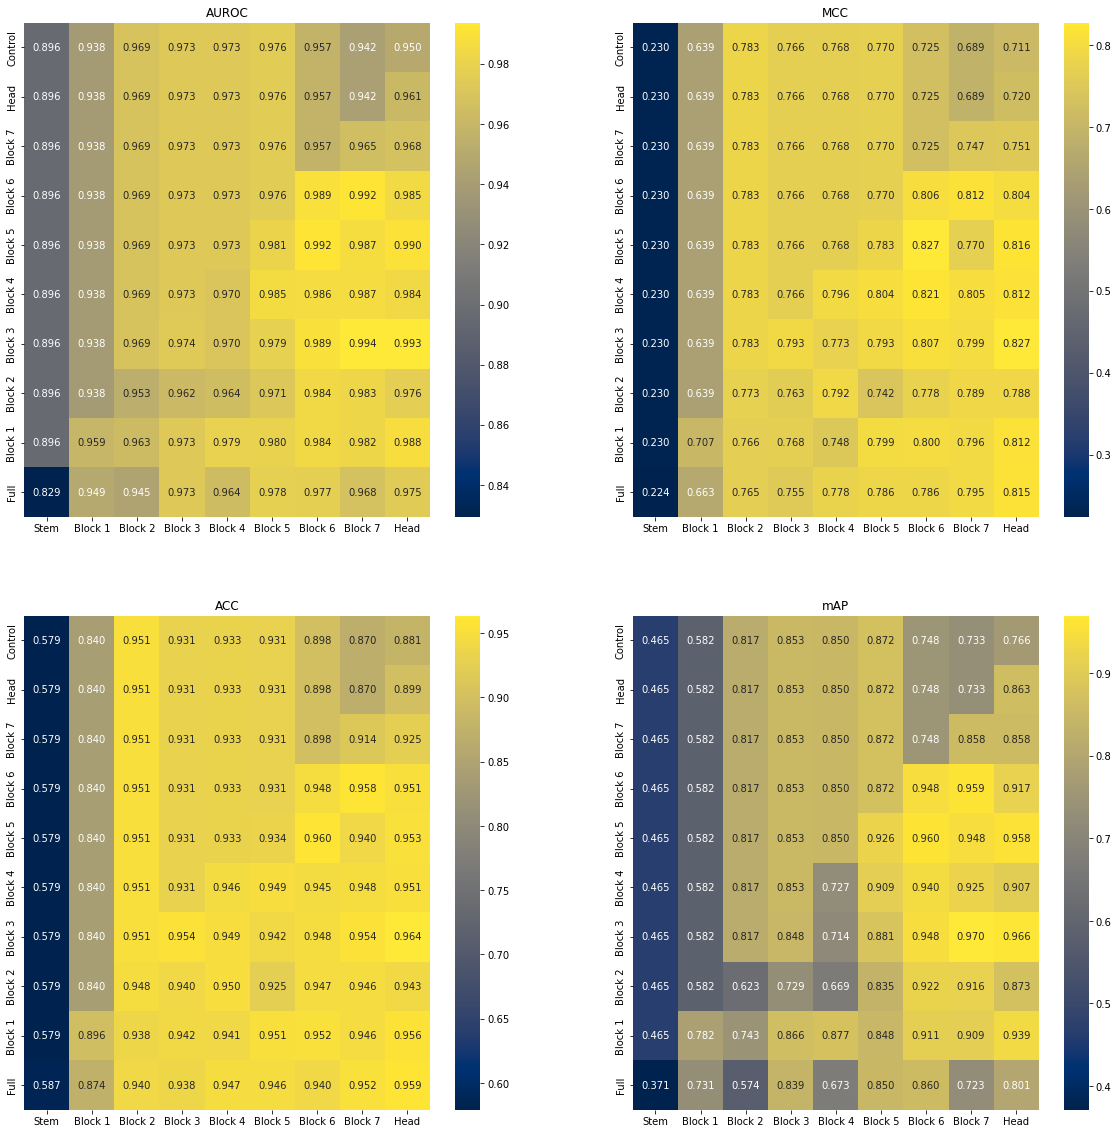

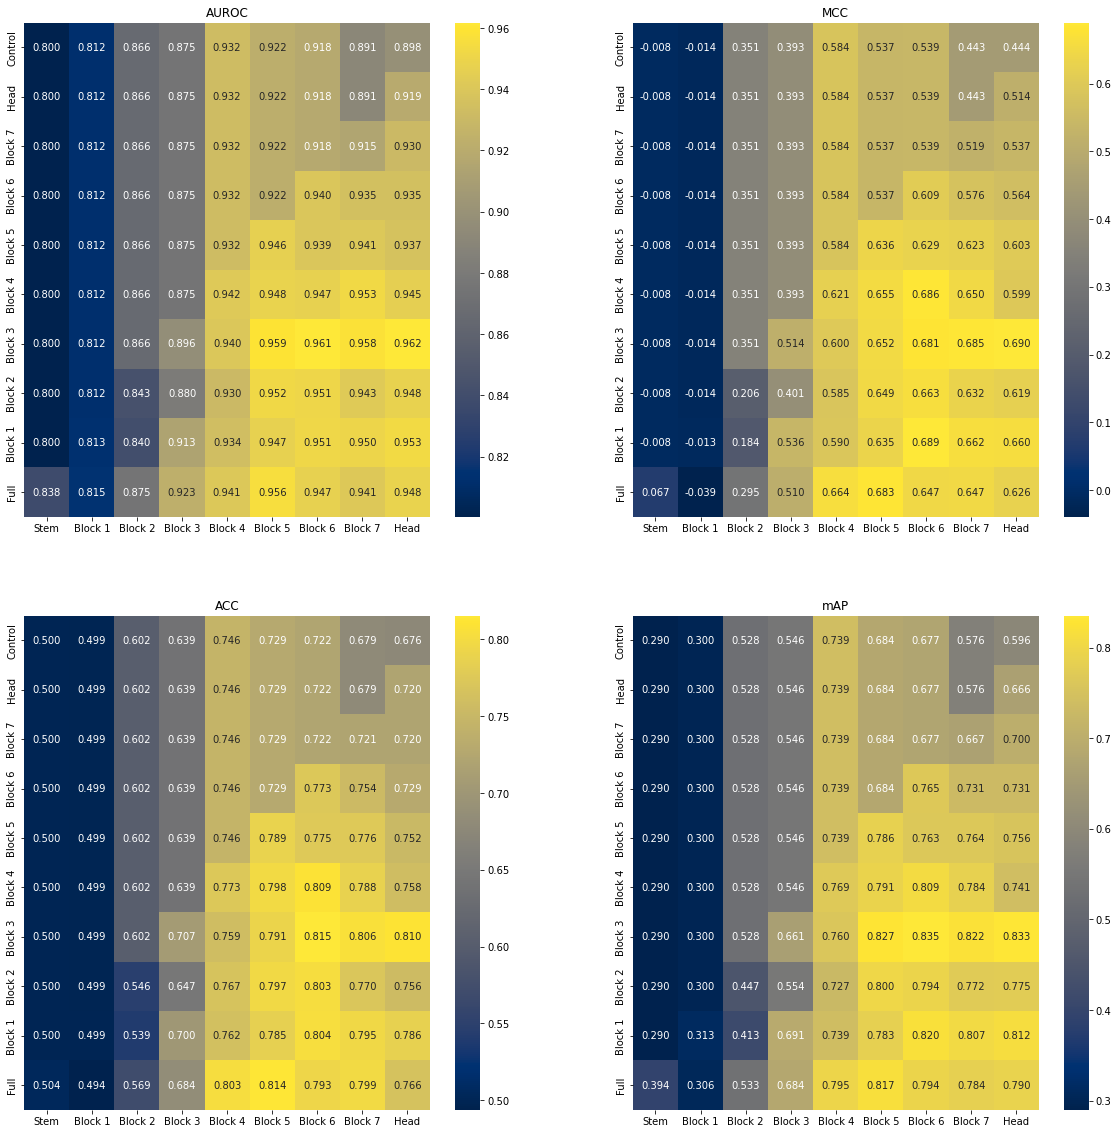

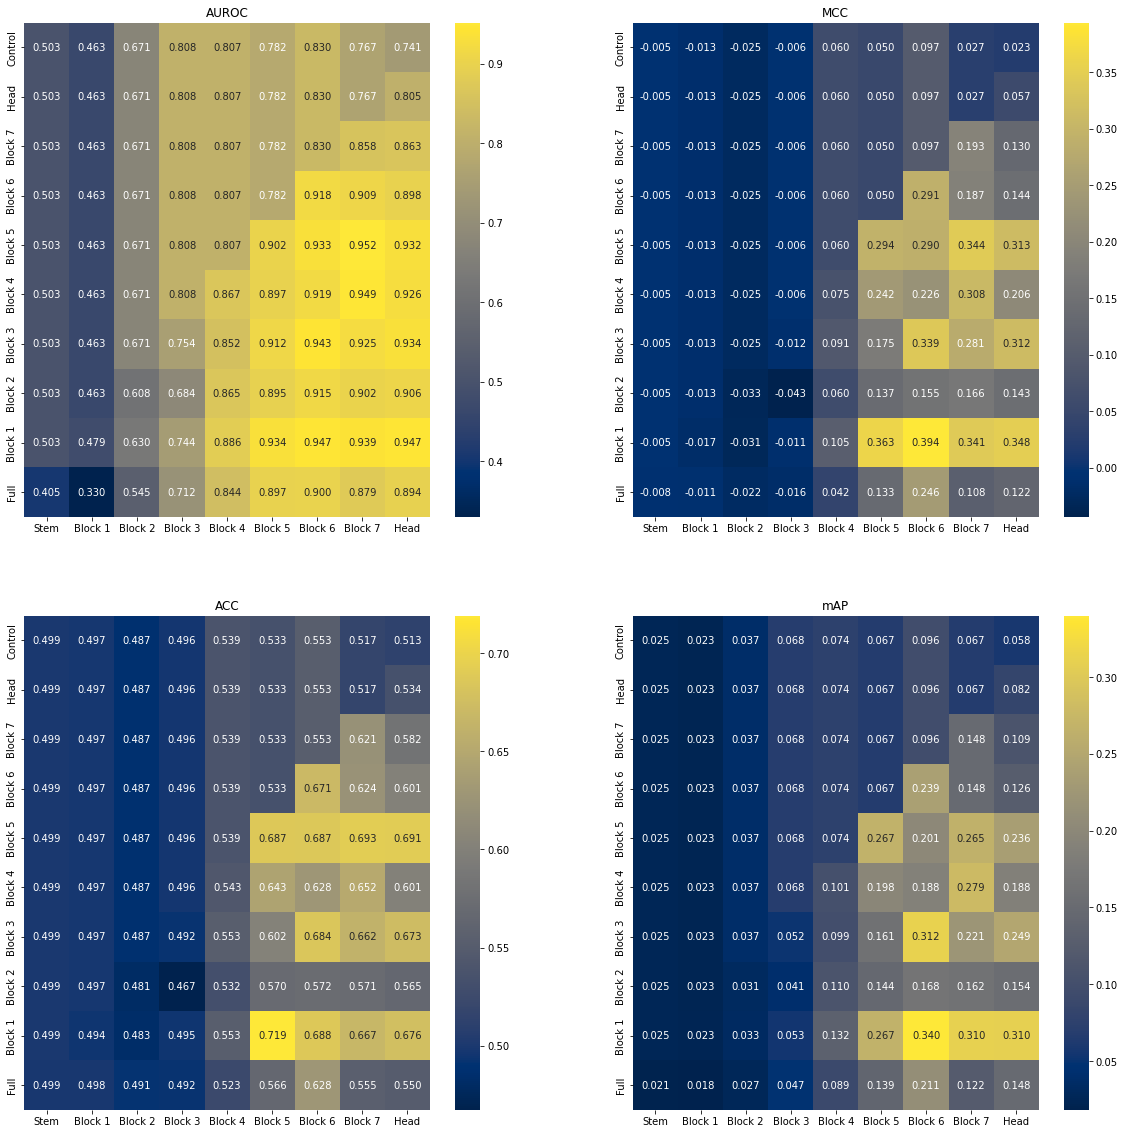

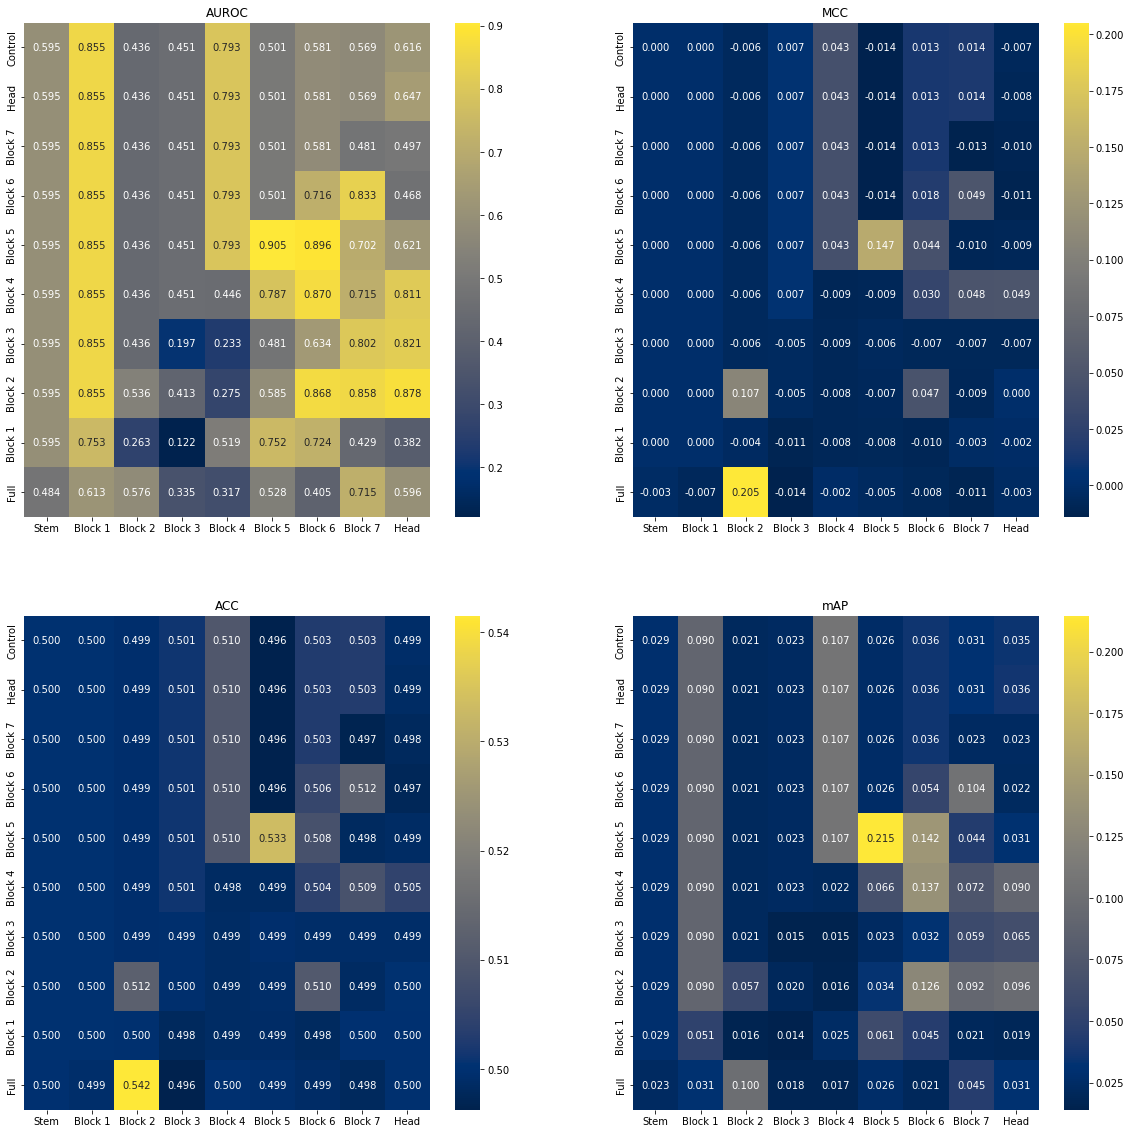

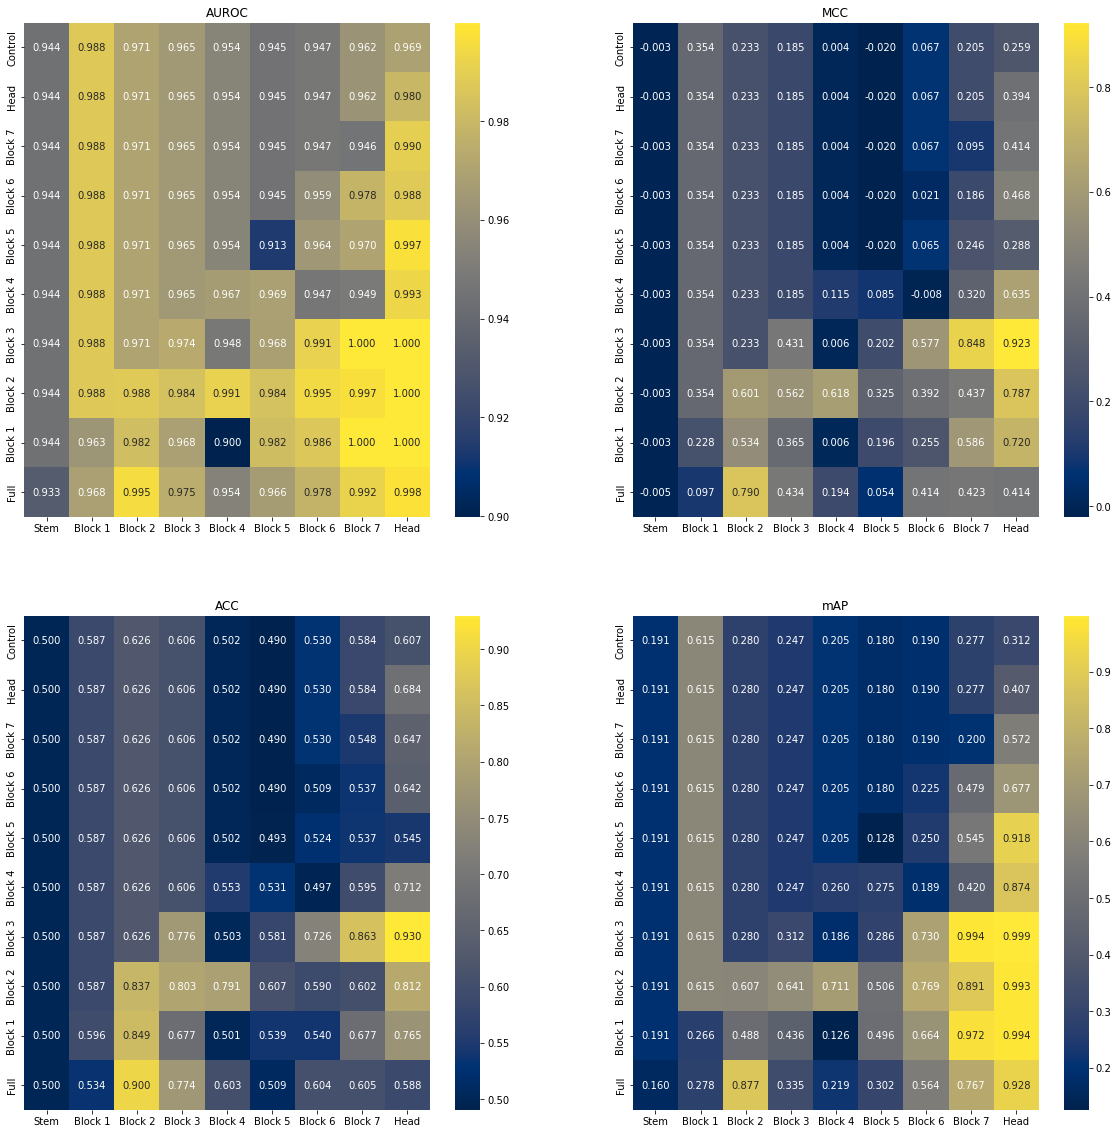

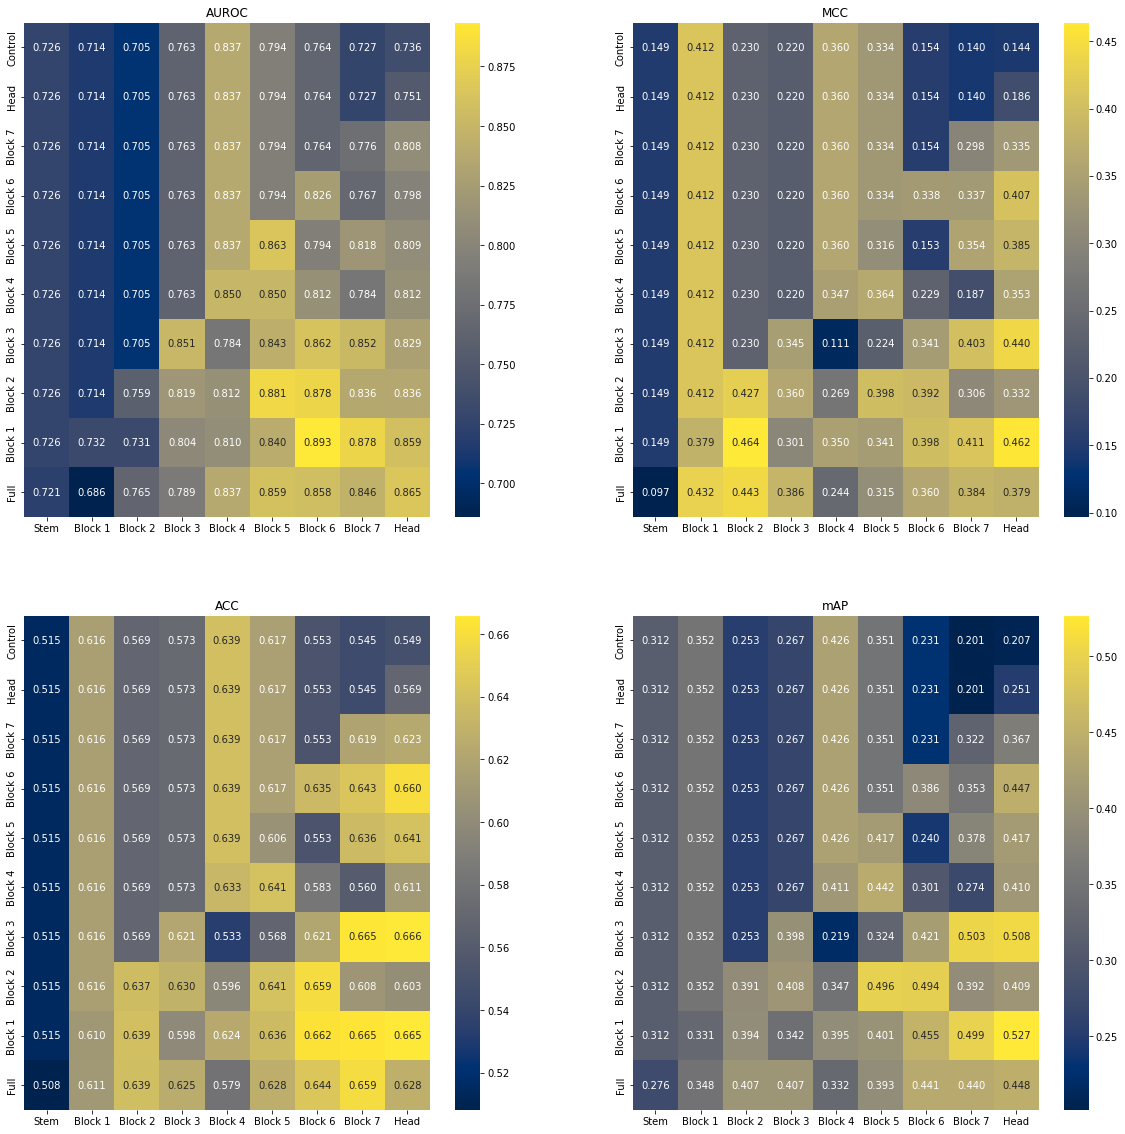

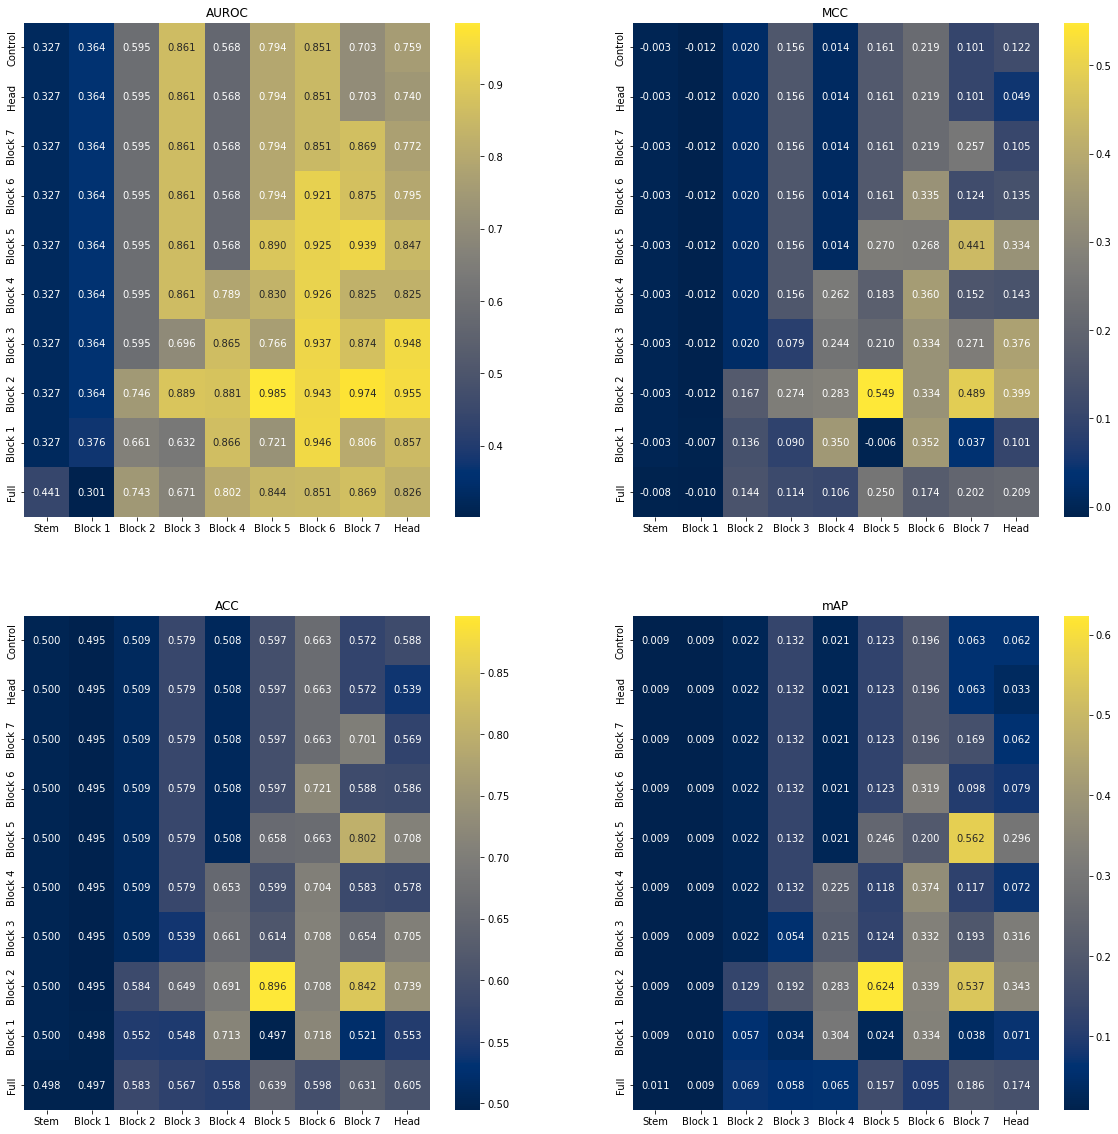

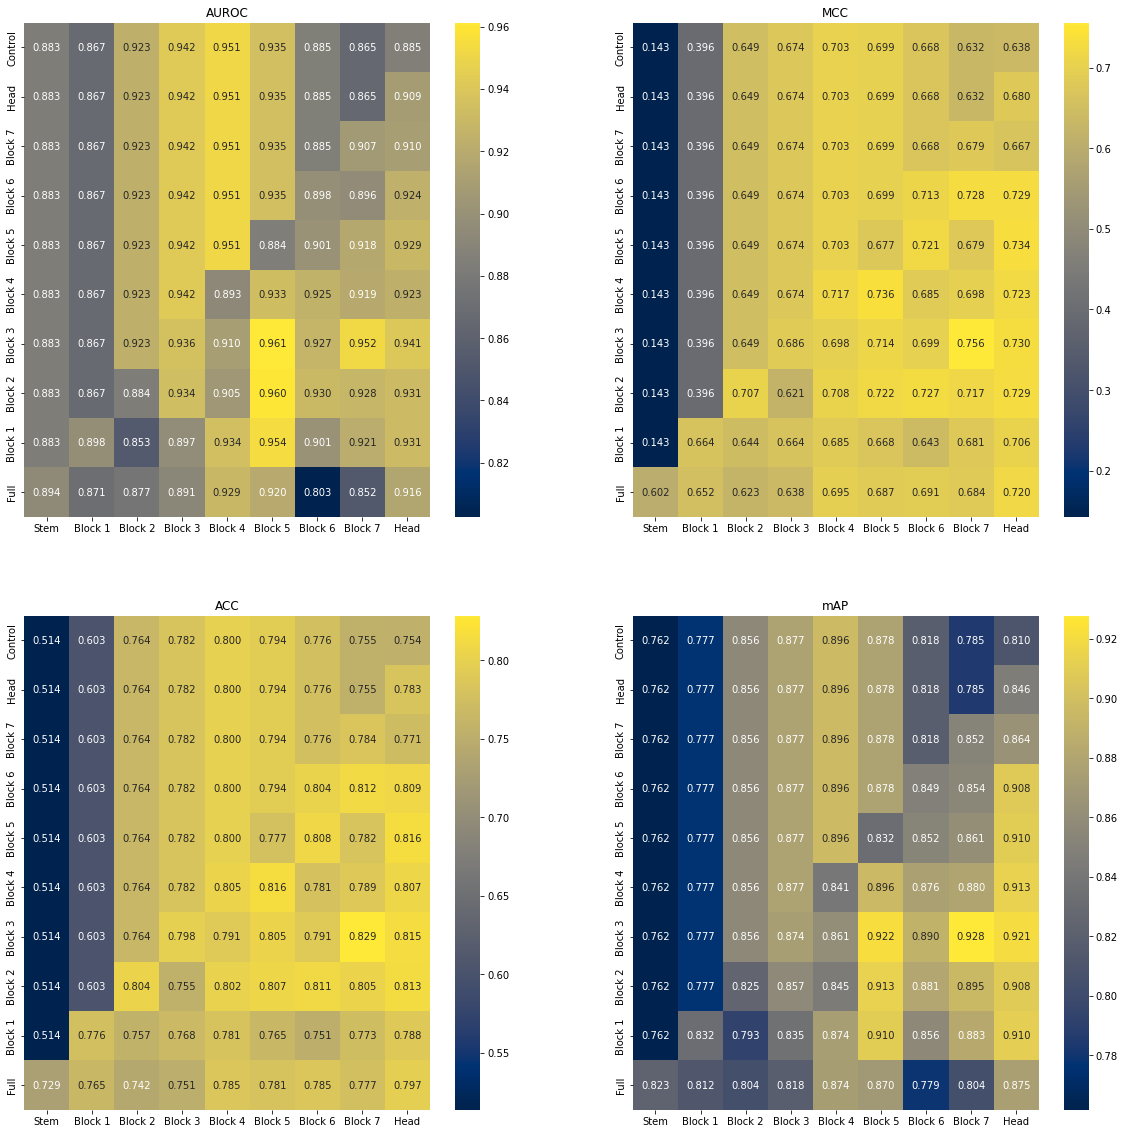

In [30]:
metrics = ["AUROC", "MCC", "ACC", "mAP"]

for ft in ft_list:
    results = res_dict[f"whole_{ft}"]
    res = np.concatenate(results[1:]).reshape(9, 9, 4)
    r = res[0:1, :, :].copy()
    r[0, -1, 0] = results[0][0][0]
    r[0, -1, 1] = results[0][0][1]
    r[0, -1, 2] = results[0][0][2]
    r[0, -1, 3] = results[0][0][3]
    res = np.concatenate([r, res])

    fig = plt.figure(figsize=(20, 20))
    for i in range(4):
        df = pd.DataFrame(res[:, :, i], index=model_name, columns=layer_name)
        ax = fig.add_subplot(2, 2, i + 1)
        sns.heatmap(df, cmap="cividis", annot=True, fmt=".3f", ax=ax)
        ax.set_title(metrics[i])
    plt.savefig(f"../../outputs/230308TGGATE_findingtype_figures_seed124_epoch5/{ft}.png", bbox_inches="tight")
    plt.show()


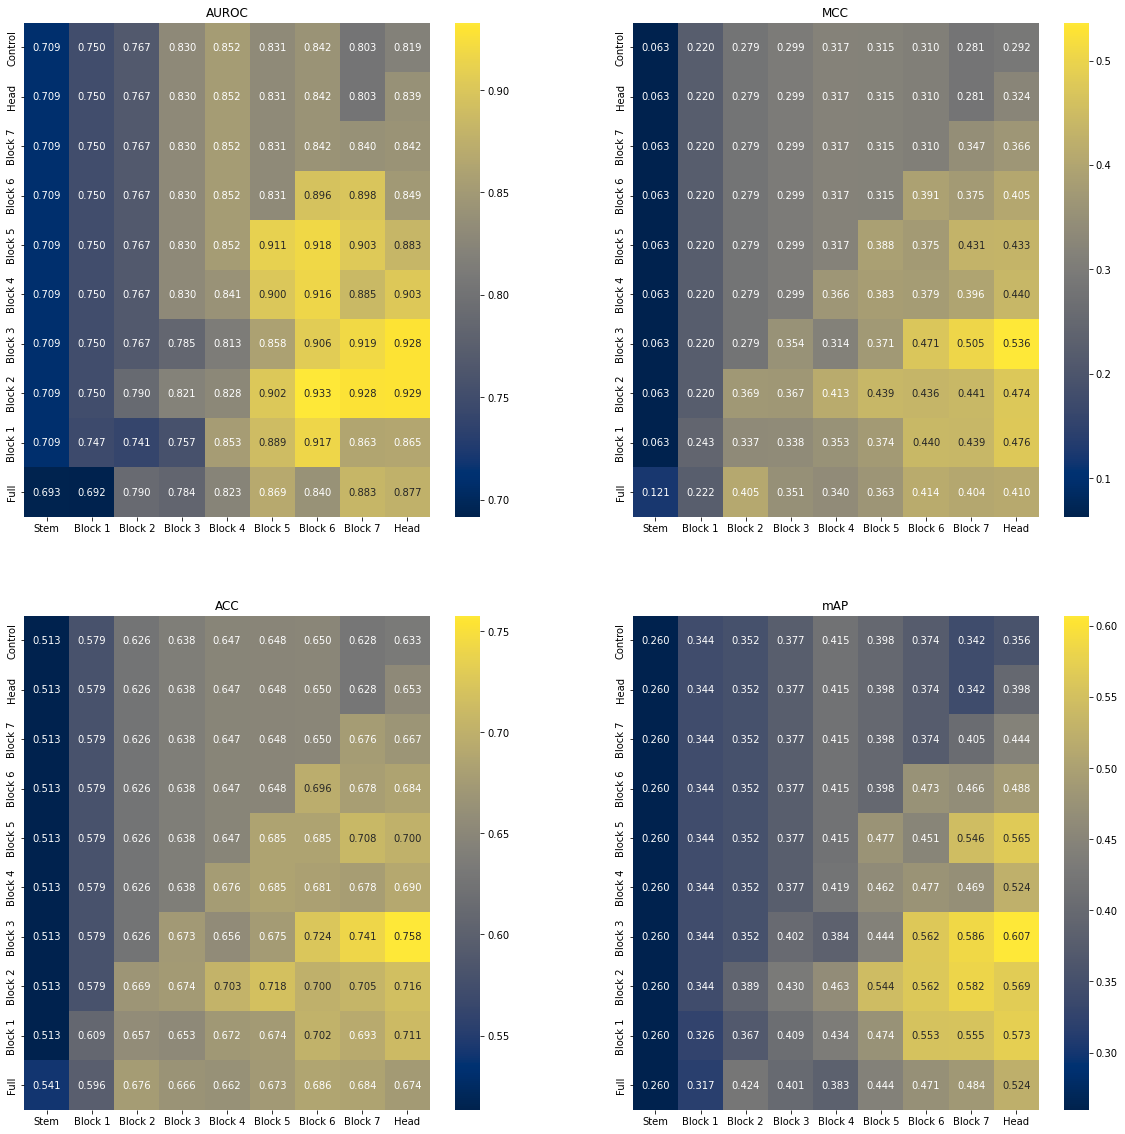

In [31]:
metrics = ["AUROC", "MCC", "ACC", "mAP"]
res_mean = 0
for ft in ft_list:
    results = res_dict[f"whole_{ft}"]
    res = np.concatenate(results[1:]).reshape(9, 9, 4)
    r = res[0:1, :, :].copy()
    r[0, -1, 0] = results[0][0][0]
    r[0, -1, 1] = results[0][0][1]
    r[0, -1, 2] = results[0][0][2]
    r[0, -1, 3] = results[0][0][3]
    res = np.concatenate([r, res])
    res_mean += res

fig = plt.figure(figsize=(20, 20))
for i in range(4):
    df = pd.DataFrame(res_mean[:, :, i]/len(ft_list), index=model_name, columns=layer_name)
    ax = fig.add_subplot(2, 2, i + 1)
    sns.heatmap(df, cmap="cividis", annot=True, fmt=".3f", ax=ax)
    ax.set_title(metrics[i])
plt.savefig(f"../../outputs/230308TGGATE_findingtype_figures_seed124_epoch5/mean.png", bbox_inches="tight")
plt.show()
